In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [12]:
import pandas as pd
import numpy as np
import os
import sys
from tqdm import tqdm

try:
    from . import data_fetcher
except:
    import data_fetcher
from pathlib import Path
import multiprocessing
from pprint import pprint
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)
try:
    from . import base_DAGMM
except:
    import base_DAGMM

Current device  >>  cuda
Current device  >>  cuda


In [133]:
def visualize( model_obj, x1,x2 ):
   
    from sklearn.decomposition import TruncatedSVD
    try :
        %matplotlib inline
    except:
        pass
    import matplotlib.pyplot as plt
    
    x1 = model_obj.get_compressed_embedding(x1)
    x2 = model_obj.get_compressed_embedding(x2)
    
    svd = TruncatedSVD(n_components=2, n_iter=100, random_state=42)
    x = np.vstack([x1,x2])
    x3 = svd.fit_transform(x)

    plt.figure(figsize=[10,10])
    plt.scatter(x3[:len(x1),0], x3[:len(x1),1], c='g',alpha=0.95)
    plt.scatter(x3[len(x1):,0], x3[len(x1):,1], c='r',alpha=0.35)
    plt.show()
    
    svd = TruncatedSVD(n_components=3, n_iter=100, random_state=42)
    x = np.vstack([x1,x2])
    x3 = svd.fit_transform(x)
    fig = plt.figure(figsize=[14,14])
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter( x3[:len(x1),0], x3[:len(x1),1], x3[:len(x1),2], c ='g',alpha=0.95 , marker='o')
    ax.scatter( x3[len(x1):,0], x3[len(x1):,1], x3[len(x1):,2], c ='r',alpha=0.35 , marker='o')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()
    return


In [122]:
def create_config(
        data_details_dict
):
    discrete_column_dims = data_details_dict['discrete_columns']
    # discrete_columns : { column_name : num_categories }
    real_columns = data_details_dict['real_columns']
    num_real_columns = len(real_columns)
    num_discrete_columns = len(discrete_column_dims)
    discreet_column_names = list(discrete_column_dims.keys())

    discrete_conversion_types = {
        'Source_Port': 'onehot',
        'Destination_Port': 'onehot',
        'Source_IP': 'emb',
        'Destination_IP': 'emb',
        'Protocol': 'onehot'
    }

    encoder_field_layers = {
        'Source_IP': 128,
        'Destination_IP': 128,
        'Source_Port': [64],
        'Destination_Port': [64],
        'Protocol': []
    }

    # ======================================================
    # Set encoder structure
    # =========
    latent_dim = 8
    encoder_real_FCN_structure = [64]
    encoder_FCN_to_latent = [256, latent_dim]

    encoder_structure_config = {
        'num_discrete': num_discrete_columns,
        'num_real': num_real_columns,
        'ip_layers': {},
        'FC_to_latent': encoder_FCN_to_latent  # FNN after concatenating
    }

    # ---------------
    # encoder_structure_config['ip_layers']
    # Format :
    # [ 'emb|onehot', num_categories, [ embedding dimension ]
    # ---------------
    for i in range(num_discrete_columns):
        col_name = discreet_column_names[i]
        encoder_structure_config['ip_layers'][i] = [discrete_conversion_types[col_name]] + [
            discrete_column_dims[col_name]] + [encoder_field_layers[col_name]]

    encoder_structure_config['ip_layers']['real'] = encoder_real_FCN_structure

    # ======================================================
    # Set decoder structure
    # =========

    FC_from_latent = [64]
    decoder_structure_config = {
        "num_discrete": num_discrete_columns,
        "num_real": num_real_columns,
        "FC_from_latent": FC_from_latent,
        "op_FC_layers": {}
    }

    # ================
    # Format decoder_field_layers:
    # { idx : [[dim1,dim2], op_activation ]
    # ================

    decoder_field_layers = {
        'Source_IP': [128, 512] + [discrete_column_dims['Source_IP']],
        'Destination_IP': [128, 512] + [discrete_column_dims['Destination_IP']],
        'Source_Port': [64] + [discrete_column_dims['Source_Port']],
        'Destination_Port': [64] + [discrete_column_dims['Destination_Port']],
        'Protocol': [8] + [discrete_column_dims['Protocol']]
    }

    for i in range(num_discrete_columns):
        col_name = discreet_column_names[i]
        decoder_structure_config['op_FC_layers'][i] = [decoder_field_layers[col_name], None]

    # =========
    # Set decoder structure for real op
    # =========
    decoder_structure_config['op_FC_layers']['real'] = [[128] + [num_real_columns]] + ['tanh']

    # ===
    # Each entry ::
    # { 'dim': <>, 'loss': <bce|mse|smooth_l1>, 'type' : <onehot|real> }
    # ===
    loss_structure_config = []

    for i in range(num_discrete_columns):
        col_name = discreet_column_names[i]
        loss_structure_config.append(
            {
                'dim': discrete_column_dims[col_name],
                'loss': 'bce',
                'type': 'onehot'
            }
        )
    loss_structure_config.append(
        {
            'dim': num_real_columns,
            'loss': 'smooth_l1',
            'type': 'real'
        }
    )

    return encoder_structure_config, decoder_structure_config, loss_structure_config, latent_dim

In [5]:
def viz_loss(losses):
    import matplotlib.pyplot as plt
    plt.figure(figsize=[8,6])
    plt.plot(list(range(len(losses[5:]))),losses[5:])
    plt.show()
    return


In [6]:
data_details_dict = data_fetcher.get_data_v1()
data = data_details_dict['data_dict']
train_df = data['train']
train_X = train_df.values

100%|██████████| 77/77 [00:39<00:00,  1.97it/s]


In [123]:
encoder_structure_config, decoder_structure_config, loss_structure_config, latent_dim = create_config(
    data_details_dict
)
pprint(encoder_structure_config)
pprint(decoder_structure_config)

{'FC_to_latent': [256, 8],
 'ip_layers': {0: ['onehot', 71, [64]],
               1: ['emb', 1027, 128],
               2: ['emb', 2128, 128],
               3: ['onehot', 160, [64]],
               4: ['onehot', 3, []],
               'real': [64]},
 'num_discrete': 5,
 'num_real': 77}
{'FC_from_latent': [64],
 'num_discrete': 5,
 'num_real': 77,
 'op_FC_layers': {0: [[64, 71], None],
                  1: [[128, 512, 1027], None],
                  2: [[128, 512, 2128], None],
                  3: [[64, 160], None],
                  4: [[8, 3], None],
                  'real': [[128, 77], 'tanh']}}


In [125]:
ae_model = base_DAGMM.AE_model(
    DEVICE,
    latent_dim,
    encoder_structure_config,
    decoder_structure_config,
    loss_structure_config,
    num_gmm_components = 8,
    optimizer='Adam',
    batch_size=128,
    num_epochs=25,
    learning_rate=0.01,
    l2_regularizer=0.05
)

losses = ae_model.train_model(
    train_X
)

  0%|          | 0/25 [00:00<?, ?it/s]

[Concatenated input ...] 451
Loss structure config [{'dim': 71, 'loss': 'bce', 'type': 'onehot'}, {'dim': 1027, 'loss': 'bce', 'type': 'onehot'}, {'dim': 2128, 'loss': 'bce', 'type': 'onehot'}, {'dim': 160, 'loss': 'bce', 'type': 'onehot'}, {'dim': 3, 'loss': 'bce', 'type': 'onehot'}, {'dim': 77, 'loss': 'smooth_l1', 'type': 'real'}]
 Epoch 0 Batch 0 Loss 2364.6243 [ AE 2364.6243 GMM 0.0000
 Epoch 0 Batch 100 Loss 26.6895 [ AE 26.6895 GMM 0.0000
 Epoch 0 Batch 200 Loss 29.1960 [ AE 29.1960 GMM 0.0000
 Epoch 0 Batch 300 Loss 20.8845 [ AE 20.8845 GMM 0.0000
 Epoch 0 Batch 400 Loss 22.4259 [ AE 22.4259 GMM 0.0000
 Epoch 0 Batch 500 Loss 19.8173 [ AE 19.8173 GMM 0.0000
 Epoch 0 Batch 600 Loss 22.7677 [ AE 22.7677 GMM 0.0000
 Epoch 0 Batch 700 Loss 18.6351 [ AE 18.6351 GMM 0.0000
 Epoch 0 Batch 800 Loss 20.7194 [ AE 20.7194 GMM 0.0000
 Epoch 0 Batch 900 Loss 22.9795 [ AE 22.9795 GMM 0.0000
 Epoch 0 Batch 1000 Loss 21.4503 [ AE 21.4503 GMM 0.0000


  4%|▍         | 1/25 [00:28<11:14, 28.11s/it]

Epoch loss :: 26.301977
 Epoch 1 Batch 0 Loss 20.5928 [ AE 20.5928 GMM 0.0000
 Epoch 1 Batch 100 Loss 18.0139 [ AE 18.0139 GMM 0.0000
 Epoch 1 Batch 200 Loss 22.7231 [ AE 22.7231 GMM 0.0000
 Epoch 1 Batch 300 Loss 20.1175 [ AE 20.1175 GMM 0.0000
 Epoch 1 Batch 400 Loss 20.4069 [ AE 20.4069 GMM 0.0000
 Epoch 1 Batch 500 Loss 19.9356 [ AE 19.9356 GMM 0.0000
 Epoch 1 Batch 600 Loss 16.9962 [ AE 16.9962 GMM 0.0000
 Epoch 1 Batch 700 Loss 19.8099 [ AE 19.8099 GMM 0.0000
 Epoch 1 Batch 800 Loss 19.8684 [ AE 19.8684 GMM 0.0000
 Epoch 1 Batch 900 Loss 20.2624 [ AE 20.2624 GMM 0.0000
 Epoch 1 Batch 1000 Loss 19.3336 [ AE 19.3336 GMM 0.0000


  8%|▊         | 2/25 [00:56<10:48, 28.22s/it]

Epoch loss :: 19.43048
 Epoch 2 Batch 0 Loss 16.0108 [ AE 16.0108 GMM 0.0000
 Epoch 2 Batch 100 Loss 19.4525 [ AE 19.4525 GMM 0.0000
 Epoch 2 Batch 200 Loss 15.5039 [ AE 15.5039 GMM 0.0000
 Epoch 2 Batch 300 Loss 16.1122 [ AE 16.1122 GMM 0.0000
 Epoch 2 Batch 400 Loss 19.1309 [ AE 19.1309 GMM 0.0000
 Epoch 2 Batch 500 Loss 18.7192 [ AE 18.7192 GMM 0.0000
 Epoch 2 Batch 600 Loss 19.4077 [ AE 19.4077 GMM 0.0000
 Epoch 2 Batch 700 Loss 20.3114 [ AE 20.3114 GMM 0.0000
 Epoch 2 Batch 800 Loss 15.4149 [ AE 15.4149 GMM 0.0000
 Epoch 2 Batch 900 Loss 15.0810 [ AE 15.0810 GMM 0.0000
 Epoch 2 Batch 1000 Loss 20.8649 [ AE 20.8649 GMM 0.0000


 12%|█▏        | 3/25 [01:24<10:21, 28.24s/it]

Epoch loss :: 18.593618
 Epoch 3 Batch 0 Loss 18.8618 [ AE 18.8618 GMM 0.0000
 Epoch 3 Batch 100 Loss 16.5766 [ AE 16.5766 GMM 0.0000
 Epoch 3 Batch 200 Loss 21.9500 [ AE 21.9500 GMM 0.0000
 Epoch 3 Batch 300 Loss 21.3756 [ AE 21.3756 GMM 0.0000
 Epoch 3 Batch 400 Loss 21.2543 [ AE 21.2543 GMM 0.0000
 Epoch 3 Batch 500 Loss 19.8229 [ AE 19.8229 GMM 0.0000
 Epoch 3 Batch 600 Loss 29.6338 [ AE 29.6338 GMM 0.0000
 Epoch 3 Batch 700 Loss 21.9614 [ AE 21.9614 GMM 0.0000
 Epoch 3 Batch 800 Loss 30.7602 [ AE 30.7602 GMM 0.0000
 Epoch 3 Batch 900 Loss 25.6220 [ AE 25.6220 GMM 0.0000
 Epoch 3 Batch 1000 Loss 24.7370 [ AE 24.7370 GMM 0.0000


 16%|█▌        | 4/25 [01:53<09:53, 28.25s/it]

Epoch loss :: 21.336384
 Epoch 4 Batch 0 Loss 20.2478 [ AE 20.2478 GMM 0.0000
 Epoch 4 Batch 100 Loss 23.3884 [ AE 23.3884 GMM 0.0000
 Epoch 4 Batch 200 Loss 19.9571 [ AE 19.9571 GMM 0.0000
 Epoch 4 Batch 300 Loss 18.6226 [ AE 18.6226 GMM 0.0000
 Epoch 4 Batch 400 Loss 28.0047 [ AE 28.0047 GMM 0.0000
 Epoch 4 Batch 500 Loss 22.2432 [ AE 22.2432 GMM 0.0000
 Epoch 4 Batch 600 Loss 22.9397 [ AE 22.9397 GMM 0.0000
 Epoch 4 Batch 700 Loss 25.0142 [ AE 25.0142 GMM 0.0000
 Epoch 4 Batch 800 Loss 25.6052 [ AE 25.6052 GMM 0.0000
 Epoch 4 Batch 900 Loss 24.1796 [ AE 24.1796 GMM 0.0000
 Epoch 4 Batch 1000 Loss 24.0948 [ AE 24.0948 GMM 0.0000


 20%|██        | 5/25 [02:21<09:26, 28.31s/it]

Epoch loss :: 23.53665
 Epoch 5 Batch 0 Loss 27.8123 [ AE 27.8123 GMM 0.0000
 Epoch 5 Batch 100 Loss 23.0149 [ AE 23.0149 GMM 0.0000
 Epoch 5 Batch 200 Loss 30.8252 [ AE 30.8252 GMM 0.0000
 Epoch 5 Batch 300 Loss 22.8864 [ AE 22.8864 GMM 0.0000
 Epoch 5 Batch 400 Loss 24.8675 [ AE 24.8675 GMM 0.0000
 Epoch 5 Batch 500 Loss 31.0580 [ AE 31.0580 GMM 0.0000
 Epoch 5 Batch 600 Loss 23.9542 [ AE 23.9542 GMM 0.0000
 Epoch 5 Batch 700 Loss 25.1020 [ AE 25.1020 GMM 0.0000
 Epoch 5 Batch 800 Loss 21.6235 [ AE 21.6235 GMM 0.0000
 Epoch 5 Batch 900 Loss 25.4516 [ AE 25.4516 GMM 0.0000
 Epoch 5 Batch 1000 Loss 21.1081 [ AE 21.1081 GMM 0.0000


 24%|██▍       | 6/25 [02:49<08:56, 28.24s/it]

Epoch loss :: 23.651407
 Epoch 6 Batch 0 Loss 20.5529 [ AE 20.5529 GMM 0.0000
 Epoch 6 Batch 100 Loss 25.5802 [ AE 25.5802 GMM 0.0000
 Epoch 6 Batch 200 Loss 22.3179 [ AE 22.3179 GMM 0.0000
 Epoch 6 Batch 300 Loss 22.8935 [ AE 22.8935 GMM 0.0000
 Epoch 6 Batch 400 Loss 25.7155 [ AE 25.7155 GMM 0.0000
 Epoch 6 Batch 500 Loss 30.2750 [ AE 30.2750 GMM 0.0000
 Epoch 6 Batch 600 Loss 28.6015 [ AE 28.6015 GMM 0.0000
 Epoch 6 Batch 700 Loss 18.9534 [ AE 18.9534 GMM 0.0000
 Epoch 6 Batch 800 Loss 23.1498 [ AE 23.1498 GMM 0.0000
 Epoch 6 Batch 900 Loss 24.3326 [ AE 24.3326 GMM 0.0000
 Epoch 6 Batch 1000 Loss 21.3525 [ AE 21.3525 GMM 0.0000


 28%|██▊       | 7/25 [03:17<08:28, 28.24s/it]

Epoch loss :: 23.69319
 Epoch 7 Batch 0 Loss 21.1364 [ AE 21.1364 GMM 0.0000
 Epoch 7 Batch 100 Loss 26.5496 [ AE 26.5496 GMM 0.0000
 Epoch 7 Batch 200 Loss 21.5029 [ AE 21.5029 GMM 0.0000
 Epoch 7 Batch 300 Loss 22.4731 [ AE 22.4731 GMM 0.0000
 Epoch 7 Batch 400 Loss 22.6632 [ AE 22.6632 GMM 0.0000
 Epoch 7 Batch 500 Loss 25.5460 [ AE 25.5460 GMM 0.0000
 Epoch 7 Batch 600 Loss 21.5033 [ AE 21.5033 GMM 0.0000
 Epoch 7 Batch 700 Loss 21.7384 [ AE 21.7384 GMM 0.0000
 Epoch 7 Batch 800 Loss 32.0884 [ AE 32.0884 GMM 0.0000
 Epoch 7 Batch 900 Loss 29.4466 [ AE 29.4466 GMM 0.0000
 Epoch 7 Batch 1000 Loss 28.9163 [ AE 28.9163 GMM 0.0000


 32%|███▏      | 8/25 [03:46<08:01, 28.35s/it]

Epoch loss :: 24.365162
 Epoch 8 Batch 0 Loss 20.9765 [ AE 20.9765 GMM 0.0000
 Epoch 8 Batch 100 Loss 22.2960 [ AE 22.2960 GMM 0.0000
 Epoch 8 Batch 200 Loss 18.9483 [ AE 18.9483 GMM 0.0000
 Epoch 8 Batch 300 Loss 29.4884 [ AE 29.4884 GMM 0.0000
 Epoch 8 Batch 400 Loss 29.9317 [ AE 29.9317 GMM 0.0000
 Epoch 8 Batch 500 Loss 25.4218 [ AE 25.4218 GMM 0.0000
 Epoch 8 Batch 600 Loss 18.5913 [ AE 18.5913 GMM 0.0000
 Epoch 8 Batch 700 Loss 24.6808 [ AE 24.6808 GMM 0.0000
 Epoch 8 Batch 800 Loss 28.5293 [ AE 28.5293 GMM 0.0000
 Epoch 8 Batch 900 Loss 22.6926 [ AE 22.6926 GMM 0.0000
 Epoch 8 Batch 1000 Loss 26.2264 [ AE 26.2264 GMM 0.0000


 36%|███▌      | 9/25 [04:15<07:34, 28.41s/it]

Epoch loss :: 24.058222
 Epoch 9 Batch 0 Loss 21.7164 [ AE 21.7164 GMM 0.0000
 Epoch 9 Batch 100 Loss 28.1084 [ AE 28.1084 GMM 0.0000
 Epoch 9 Batch 200 Loss 26.8186 [ AE 26.8186 GMM 0.0000
 Epoch 9 Batch 300 Loss 24.9140 [ AE 24.9140 GMM 0.0000
 Epoch 9 Batch 400 Loss 18.1260 [ AE 18.1260 GMM 0.0000
 Epoch 9 Batch 500 Loss 24.1728 [ AE 24.1728 GMM 0.0000
 Epoch 9 Batch 600 Loss 24.5185 [ AE 24.5185 GMM 0.0000
 Epoch 9 Batch 700 Loss 25.4714 [ AE 25.4714 GMM 0.0000
 Epoch 9 Batch 800 Loss 23.7316 [ AE 23.7316 GMM 0.0000
 Epoch 9 Batch 900 Loss 19.6774 [ AE 19.6774 GMM 0.0000
 Epoch 9 Batch 1000 Loss 19.9953 [ AE 19.9953 GMM 0.0000


 40%|████      | 10/25 [04:43<07:08, 28.56s/it]

Epoch loss :: 24.09265
 Epoch 10 Batch 0 Loss 22.1800 [ AE 22.1800 GMM 0.0000
 Epoch 10 Batch 100 Loss 25.3502 [ AE 25.3502 GMM 0.0000
 Epoch 10 Batch 200 Loss 26.1281 [ AE 26.1281 GMM 0.0000
 Epoch 10 Batch 300 Loss 22.0369 [ AE 22.0369 GMM 0.0000
 Epoch 10 Batch 400 Loss 21.4300 [ AE 21.4300 GMM 0.0000
 Epoch 10 Batch 500 Loss 21.5546 [ AE 21.5546 GMM 0.0000
 Epoch 10 Batch 600 Loss 27.9915 [ AE 27.9915 GMM 0.0000
 Epoch 10 Batch 700 Loss 23.8496 [ AE 23.8496 GMM 0.0000
 Epoch 10 Batch 800 Loss 25.5664 [ AE 25.5664 GMM 0.0000
 Epoch 10 Batch 900 Loss 28.8136 [ AE 28.8136 GMM 0.0000
 Epoch 10 Batch 1000 Loss 25.3268 [ AE 25.3268 GMM 0.0000


 44%|████▍     | 11/25 [05:12<06:39, 28.50s/it]

Epoch loss :: 24.61932
 Epoch 11 Batch 0 Loss 23.4799 [ AE 23.4799 GMM 0.0000
 Epoch 11 Batch 100 Loss 22.3563 [ AE 22.3563 GMM 0.0000
 Epoch 11 Batch 200 Loss 26.4326 [ AE 26.4326 GMM 0.0000
 Epoch 11 Batch 300 Loss 29.0273 [ AE 29.0273 GMM 0.0000
 Epoch 11 Batch 400 Loss 24.4311 [ AE 24.4311 GMM 0.0000
 Epoch 11 Batch 500 Loss 28.6799 [ AE 28.6799 GMM 0.0000
 Epoch 11 Batch 600 Loss 30.4514 [ AE 30.4514 GMM 0.0000
 Epoch 11 Batch 700 Loss 22.8873 [ AE 22.8873 GMM 0.0000
 Epoch 11 Batch 800 Loss 22.4026 [ AE 22.4026 GMM 0.0000
 Epoch 11 Batch 900 Loss 26.5874 [ AE 26.5874 GMM 0.0000
 Epoch 11 Batch 1000 Loss 28.7522 [ AE 28.7522 GMM 0.0000


 48%|████▊     | 12/25 [05:40<06:10, 28.51s/it]

Epoch loss :: 25.65084
 Epoch 12 Batch 0 Loss 24.9203 [ AE 24.9203 GMM 0.0000
 Epoch 12 Batch 100 Loss 23.9546 [ AE 23.9546 GMM 0.0000
 Epoch 12 Batch 200 Loss 24.0717 [ AE 24.0717 GMM 0.0000
 Epoch 12 Batch 300 Loss 22.7531 [ AE 22.7531 GMM 0.0000
 Epoch 12 Batch 400 Loss 22.7101 [ AE 22.7101 GMM 0.0000
 Epoch 12 Batch 500 Loss 23.2132 [ AE 23.2132 GMM 0.0000
 Epoch 12 Batch 600 Loss 21.2056 [ AE 21.2056 GMM 0.0000
 Epoch 12 Batch 700 Loss 22.5025 [ AE 22.5025 GMM 0.0000
 Epoch 12 Batch 800 Loss 20.5704 [ AE 20.5704 GMM 0.0000
 Epoch 12 Batch 900 Loss 22.1392 [ AE 22.1392 GMM 0.0000
 Epoch 12 Batch 1000 Loss 21.6144 [ AE 21.6144 GMM 0.0000


 52%|█████▏    | 13/25 [06:09<05:43, 28.61s/it]

Epoch loss :: 24.803392
 Epoch 13 Batch 0 Loss 26.6541 [ AE 26.6541 GMM 0.0000
 Epoch 13 Batch 100 Loss 22.8123 [ AE 22.8123 GMM 0.0000
 Epoch 13 Batch 200 Loss 21.9645 [ AE 21.9645 GMM 0.0000
 Epoch 13 Batch 300 Loss 28.0671 [ AE 28.0671 GMM 0.0000
 Epoch 13 Batch 400 Loss 29.5796 [ AE 29.5796 GMM 0.0000
 Epoch 13 Batch 500 Loss 26.1322 [ AE 26.1322 GMM 0.0000
 Epoch 13 Batch 600 Loss 26.6069 [ AE 26.6069 GMM 0.0000
 Epoch 13 Batch 700 Loss 19.2464 [ AE 19.2464 GMM 0.0000
 Epoch 13 Batch 800 Loss 21.1874 [ AE 21.1874 GMM 0.0000
 Epoch 13 Batch 900 Loss 30.5214 [ AE 30.5214 GMM 0.0000
 Epoch 13 Batch 1000 Loss 22.1552 [ AE 22.1552 GMM 0.0000


 56%|█████▌    | 14/25 [06:38<05:15, 28.65s/it]

Epoch loss :: 24.308401
 Epoch 14 Batch 0 Loss 26.3448 [ AE 26.3448 GMM 0.0000
 Epoch 14 Batch 100 Loss 23.6252 [ AE 23.6252 GMM 0.0000
 Epoch 14 Batch 200 Loss 21.6718 [ AE 21.6718 GMM 0.0000
 Epoch 14 Batch 300 Loss 19.2066 [ AE 19.2066 GMM 0.0000
 Epoch 14 Batch 400 Loss 22.9765 [ AE 22.9765 GMM 0.0000
 Epoch 14 Batch 500 Loss 21.5320 [ AE 21.5320 GMM 0.0000
 Epoch 14 Batch 600 Loss 31.2732 [ AE 31.2732 GMM 0.0000
 Epoch 14 Batch 700 Loss 20.7506 [ AE 20.7506 GMM 0.0000
 Epoch 14 Batch 800 Loss 21.1310 [ AE 21.1310 GMM 0.0000
 Epoch 14 Batch 900 Loss 24.9573 [ AE 24.9573 GMM 0.0000
 Epoch 14 Batch 1000 Loss 25.2589 [ AE 25.2589 GMM 0.0000


 60%|██████    | 15/25 [07:07<04:46, 28.65s/it]

Epoch loss :: 25.348719
 Epoch 15 Batch 0 Loss 22.6916 [ AE 22.6916 GMM 0.0000
 Epoch 15 Batch 100 Loss 21.4804 [ AE 21.4804 GMM 0.0000
 Epoch 15 Batch 200 Loss 21.6662 [ AE 21.6662 GMM 0.0000
 Epoch 15 Batch 300 Loss 23.1435 [ AE 23.1435 GMM 0.0000
 Epoch 15 Batch 400 Loss 27.4879 [ AE 27.4879 GMM 0.0000
 Epoch 15 Batch 500 Loss 26.0556 [ AE 26.0556 GMM 0.0000
 Epoch 15 Batch 600 Loss 28.4483 [ AE 28.4483 GMM 0.0000
 Epoch 15 Batch 700 Loss 24.0245 [ AE 24.0245 GMM 0.0000
 Epoch 15 Batch 800 Loss 24.4755 [ AE 24.4755 GMM 0.0000
 Epoch 15 Batch 900 Loss 28.4257 [ AE 28.4257 GMM 0.0000
 Epoch 15 Batch 1000 Loss 27.1869 [ AE 27.1869 GMM 0.0000


 64%|██████▍   | 16/25 [07:35<04:17, 28.65s/it]

Epoch loss :: 24.092392
 Epoch 16 Batch 0 Loss 23.9833 [ AE 23.9833 GMM 0.0000
 Epoch 16 Batch 100 Loss 20.8225 [ AE 20.8225 GMM 0.0000
 Epoch 16 Batch 200 Loss 25.7842 [ AE 25.7842 GMM 0.0000
 Epoch 16 Batch 300 Loss 28.8715 [ AE 28.8715 GMM 0.0000
 Epoch 16 Batch 400 Loss 19.8184 [ AE 19.8184 GMM 0.0000
 Epoch 16 Batch 500 Loss 21.9615 [ AE 21.9615 GMM 0.0000
 Epoch 16 Batch 600 Loss 26.7523 [ AE 26.7523 GMM 0.0000
 Epoch 16 Batch 700 Loss 26.4319 [ AE 26.4319 GMM 0.0000
 Epoch 16 Batch 800 Loss 23.6264 [ AE 23.6264 GMM 0.0000
 Epoch 16 Batch 900 Loss 24.1844 [ AE 24.1844 GMM 0.0000
 Epoch 16 Batch 1000 Loss 18.0766 [ AE 18.0766 GMM 0.0000


 68%|██████▊   | 17/25 [08:04<03:49, 28.65s/it]

Epoch loss :: 24.044342
 Epoch 17 Batch 0 Loss 25.4247 [ AE 25.4247 GMM 0.0000
 Epoch 17 Batch 100 Loss 25.6255 [ AE 25.6255 GMM 0.0000
 Epoch 17 Batch 200 Loss 25.0834 [ AE 25.0834 GMM 0.0000
 Epoch 17 Batch 300 Loss 20.2473 [ AE 20.2473 GMM 0.0000
 Epoch 17 Batch 400 Loss 24.8245 [ AE 24.8245 GMM 0.0000
 Epoch 17 Batch 500 Loss 29.2338 [ AE 29.2338 GMM 0.0000
 Epoch 17 Batch 600 Loss 26.2253 [ AE 26.2253 GMM 0.0000
 Epoch 17 Batch 700 Loss 21.6727 [ AE 21.6727 GMM 0.0000
 Epoch 17 Batch 800 Loss 15.4446 [ AE 15.4446 GMM 0.0000
 Epoch 17 Batch 900 Loss 21.0443 [ AE 21.0443 GMM 0.0000
 Epoch 17 Batch 1000 Loss 22.8074 [ AE 22.8074 GMM 0.0000


 72%|███████▏  | 18/25 [08:32<03:19, 28.46s/it]

Epoch loss :: 24.459066
 Epoch 18 Batch 0 Loss 21.5432 [ AE 21.5432 GMM 0.0000
 Epoch 18 Batch 100 Loss 19.2126 [ AE 19.2126 GMM 0.0000
 Epoch 18 Batch 200 Loss 28.6782 [ AE 28.6782 GMM 0.0000
 Epoch 18 Batch 300 Loss 20.5891 [ AE 20.5891 GMM 0.0000
 Epoch 18 Batch 400 Loss 23.4668 [ AE 23.4668 GMM 0.0000
 Epoch 18 Batch 500 Loss 24.5582 [ AE 24.5582 GMM 0.0000
 Epoch 18 Batch 600 Loss 23.6636 [ AE 23.6636 GMM 0.0000
 Epoch 18 Batch 700 Loss 28.0621 [ AE 28.0621 GMM 0.0000
 Epoch 18 Batch 800 Loss 25.6218 [ AE 25.6218 GMM 0.0000
 Epoch 18 Batch 900 Loss 26.4991 [ AE 26.4991 GMM 0.0000
 Epoch 18 Batch 1000 Loss 22.2636 [ AE 22.2636 GMM 0.0000


 76%|███████▌  | 19/25 [09:01<02:51, 28.50s/it]

Epoch loss :: 23.636929
 Epoch 19 Batch 0 Loss 22.9943 [ AE 22.9943 GMM 0.0000
 Epoch 19 Batch 100 Loss 19.9567 [ AE 19.9567 GMM 0.0000
 Epoch 19 Batch 200 Loss 29.0809 [ AE 29.0809 GMM 0.0000
 Epoch 19 Batch 300 Loss 21.2120 [ AE 21.2120 GMM 0.0000
 Epoch 19 Batch 400 Loss 24.8781 [ AE 24.8781 GMM 0.0000
 Epoch 19 Batch 500 Loss 27.2690 [ AE 27.2690 GMM 0.0000
 Epoch 19 Batch 600 Loss 21.6229 [ AE 21.6229 GMM 0.0000
 Epoch 19 Batch 700 Loss 22.4757 [ AE 22.4757 GMM 0.0000
 Epoch 19 Batch 800 Loss 23.8483 [ AE 23.8483 GMM 0.0000
 Epoch 19 Batch 900 Loss 26.7007 [ AE 26.7007 GMM 0.0000
 Epoch 19 Batch 1000 Loss 21.2704 [ AE 21.2704 GMM 0.0000


 80%|████████  | 20/25 [09:29<02:22, 28.45s/it]

Epoch loss :: 23.694593
 Epoch 20 Batch 0 Loss 23.9322 [ AE 23.9322 GMM 0.0000
 Epoch 20 Batch 100 Loss 21.7057 [ AE 21.7057 GMM 0.0000
 Epoch 20 Batch 200 Loss 24.2286 [ AE 24.2286 GMM 0.0000
 Epoch 20 Batch 300 Loss 19.3559 [ AE 19.3559 GMM 0.0000
 Epoch 20 Batch 400 Loss 24.0140 [ AE 24.0140 GMM 0.0000
 Epoch 20 Batch 500 Loss 23.1934 [ AE 23.1934 GMM 0.0000
 Epoch 20 Batch 600 Loss 23.1277 [ AE 23.1277 GMM 0.0000
 Epoch 20 Batch 700 Loss 20.6244 [ AE 20.6244 GMM 0.0000
 Epoch 20 Batch 800 Loss 27.9980 [ AE 27.9980 GMM 0.0000
 Epoch 20 Batch 900 Loss 22.6114 [ AE 22.6114 GMM 0.0000
 Epoch 20 Batch 1000 Loss 22.6260 [ AE 22.6260 GMM 0.0000


 84%|████████▍ | 21/25 [09:57<01:53, 28.42s/it]

Epoch loss :: 23.979422
 Epoch 21 Batch 0 Loss 24.6494 [ AE 24.6494 GMM 0.0000
 Epoch 21 Batch 100 Loss 27.9814 [ AE 27.9814 GMM 0.0000
 Epoch 21 Batch 200 Loss 25.8634 [ AE 25.8634 GMM 0.0000
 Epoch 21 Batch 300 Loss 22.8819 [ AE 22.8819 GMM 0.0000
 Epoch 21 Batch 400 Loss 24.1327 [ AE 24.1327 GMM 0.0000
 Epoch 21 Batch 500 Loss 23.2304 [ AE 23.2304 GMM 0.0000
 Epoch 21 Batch 600 Loss 21.1882 [ AE 21.1882 GMM 0.0000
 Epoch 21 Batch 700 Loss 23.1403 [ AE 23.1403 GMM 0.0000
 Epoch 21 Batch 800 Loss 21.2832 [ AE 21.2832 GMM 0.0000
 Epoch 21 Batch 900 Loss 23.4422 [ AE 23.4422 GMM 0.0000
 Epoch 21 Batch 1000 Loss 25.6908 [ AE 25.6908 GMM 0.0000


 88%|████████▊ | 22/25 [10:26<01:25, 28.41s/it]

Epoch loss :: 23.76791
 Epoch 22 Batch 0 Loss 24.8640 [ AE 24.8640 GMM 0.0000
 Epoch 22 Batch 100 Loss 28.2221 [ AE 28.2221 GMM 0.0000
 Epoch 22 Batch 200 Loss 23.4315 [ AE 23.4315 GMM 0.0000
 Epoch 22 Batch 300 Loss 26.3085 [ AE 26.3085 GMM 0.0000
 Epoch 22 Batch 400 Loss 22.8193 [ AE 22.8193 GMM 0.0000
 Epoch 22 Batch 500 Loss 29.6479 [ AE 29.6479 GMM 0.0000
 Epoch 22 Batch 600 Loss 25.9472 [ AE 25.9472 GMM 0.0000
 Epoch 22 Batch 700 Loss 24.4103 [ AE 24.4103 GMM 0.0000
 Epoch 22 Batch 800 Loss 23.2549 [ AE 23.2549 GMM 0.0000
 Epoch 22 Batch 900 Loss 25.4492 [ AE 25.4492 GMM 0.0000
 Epoch 22 Batch 1000 Loss 20.6390 [ AE 20.6390 GMM 0.0000


 92%|█████████▏| 23/25 [10:54<00:56, 28.43s/it]

Epoch loss :: 24.296486
 Epoch 23 Batch 0 Loss 22.8163 [ AE 22.8163 GMM 0.0000
 Epoch 23 Batch 100 Loss 20.2422 [ AE 20.2422 GMM 0.0000
 Epoch 23 Batch 200 Loss 21.5842 [ AE 21.5842 GMM 0.0000
 Epoch 23 Batch 300 Loss 21.4242 [ AE 21.4242 GMM 0.0000
 Epoch 23 Batch 400 Loss 27.0806 [ AE 27.0806 GMM 0.0000
 Epoch 23 Batch 500 Loss 27.0607 [ AE 27.0607 GMM 0.0000
 Epoch 23 Batch 600 Loss 25.8123 [ AE 25.8123 GMM 0.0000
 Epoch 23 Batch 700 Loss 24.0225 [ AE 24.0225 GMM 0.0000
 Epoch 23 Batch 800 Loss 27.3492 [ AE 27.3492 GMM 0.0000
 Epoch 23 Batch 900 Loss 20.6005 [ AE 20.6005 GMM 0.0000
 Epoch 23 Batch 1000 Loss 23.1933 [ AE 23.1933 GMM 0.0000


 96%|█████████▌| 24/25 [11:23<00:28, 28.57s/it]

Epoch loss :: 24.013334
 Epoch 24 Batch 0 Loss 22.9266 [ AE 22.9266 GMM 0.0000
 Epoch 24 Batch 100 Loss 26.8992 [ AE 26.8992 GMM 0.0000
 Epoch 24 Batch 200 Loss 24.2914 [ AE 24.2914 GMM 0.0000
 Epoch 24 Batch 300 Loss 23.4175 [ AE 23.4175 GMM 0.0000
 Epoch 24 Batch 400 Loss 21.4322 [ AE 21.4322 GMM 0.0000
 Epoch 24 Batch 500 Loss 21.6064 [ AE 21.6064 GMM 0.0000
 Epoch 24 Batch 600 Loss 21.9450 [ AE 21.9450 GMM 0.0000
 Epoch 24 Batch 700 Loss 23.1565 [ AE 23.1565 GMM 0.0000
 Epoch 24 Batch 800 Loss 23.1709 [ AE 23.1709 GMM 0.0000
 Epoch 24 Batch 900 Loss 21.9341 [ AE 21.9341 GMM 0.0000
 Epoch 24 Batch 1000 Loss 22.0079 [ AE 22.0079 GMM 0.0000


100%|██████████| 25/25 [11:52<00:00, 28.50s/it]

Epoch loss :: 23.595654


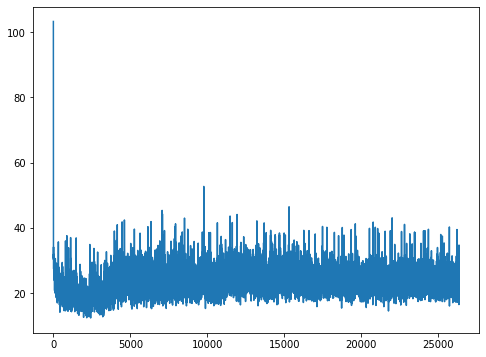

In [126]:
viz_loss(losses)

In [134]:
test_norm_df = data['test_norm']
test_norm_X = test_norm_df.values

test_anom_df = data['test_anom']
test_anom_X = test_anom_df.values
x1 = test_norm_X
x2 = test_anom_X

In [131]:
# x1 = ae_model.get_compressed_embedding(test_norm_X)
# x2 = ae_model.get_compressed_embedding(test_anom_X)

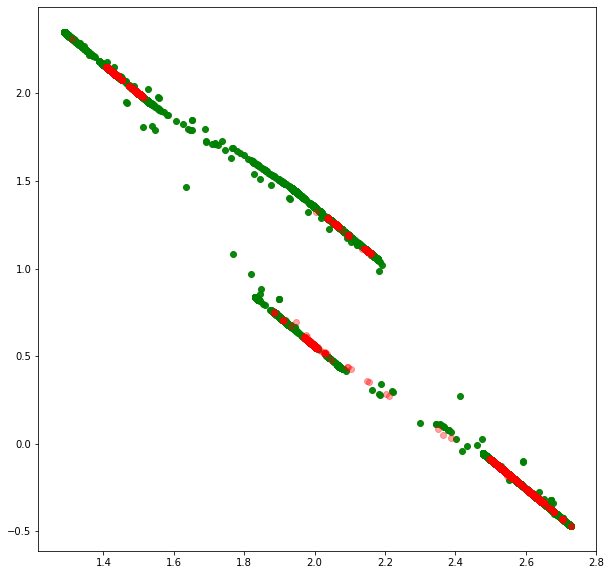

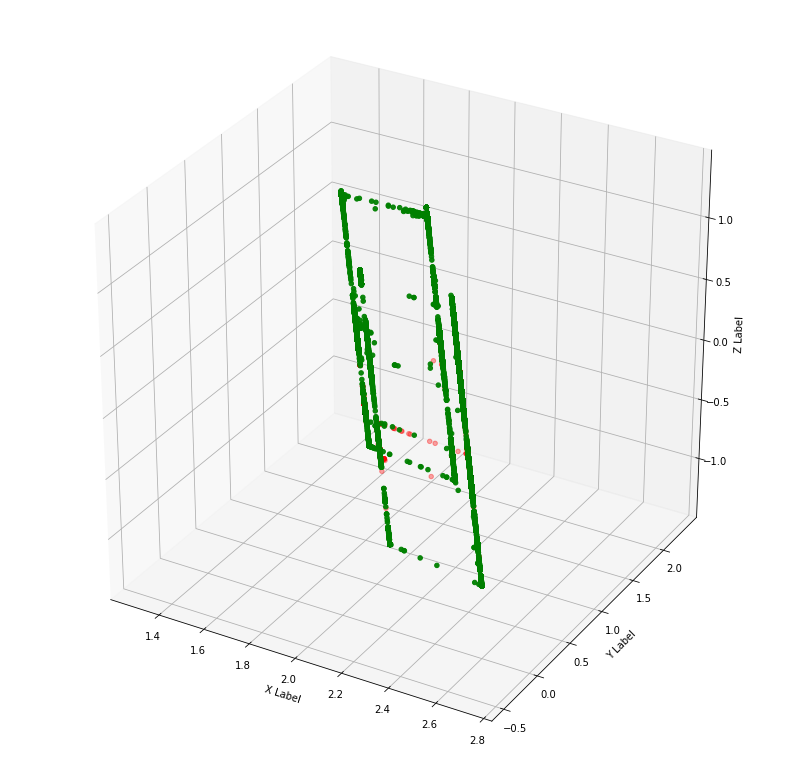

In [135]:
visualize( ae_model, x1,x2)

In [70]:
from sklearn import mixture
X = ae_model.get_compressed_embedding(train_X)

In [76]:
X = np.array(X)
X.shape

(134986, 16)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


In [105]:
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange','red','magenta','yellow'])


def plot_results(X, Y_, means, covariances, index, title):
    
    plt.figure( figsize=[8,6])
    splot = plt.subplot(1, 1, 1)
    component_count = 0
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(np.diag(covar))
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
          
        if not np.any(Y_ == i):
            continue
        else:
            c = np.nonzero(np.where(Y_ == 2, Y_, 0))[0].shape[0]
            component_count += 1
            print('component :', component_count, c )
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        
    plt.title(title)
    plt.show()

In [136]:
# Number of samples per component
n_samples = X.shape[0]
dpgmm = mixture.BayesianGaussianMixture(
    n_components = 20,
    covariance_type='diag',
    verbose=1,
    max_iter = 100
).fit(X)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True


component : 1 6514
component : 2 6514
component : 3 6514
component : 4 6514
component : 5 6514
component : 6 6514
component : 7 6514
component : 8 6514
component : 9 6514
component : 10 6514
component : 11 6514
component : 12 6514
component : 13 6514
component : 14 6514
component : 15 6514
component : 16 6514
component : 17 6514
component : 18 6514
component : 19 6514
component : 20 6514


/home/ddatta/anaconda3/envs/SG/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


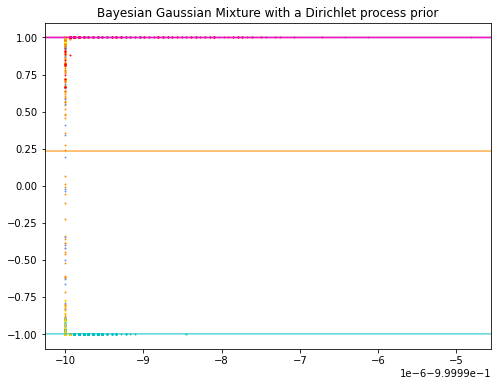

In [137]:
plot_results(
    X, 
    dpgmm.predict(X), 
    dpgmm.means_, 
    dpgmm.covariances_, 
    1,
    'Bayesian Gaussian Mixture with a Dirichlet process prior'
)

plt.show()

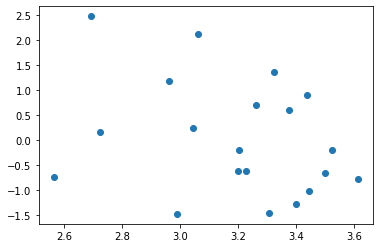

In [146]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD()
z = svd.fit_transform(dpgmm.means_)
plt.scatter(z[:,0],z[:,1])

In [23]:
sigma_k = torch.FloatTensor(np.random.random([16]))
torch.reciprocal(torch.pow(torch.prod(sigma_k, dim=0),2))
                           

tensor(5.8142e+14)

In [55]:
a =  torch.FloatTensor(np.random.random([128,16]))
b =  torch.FloatTensor(np.random.random([128]))

In [104]:
a = np.array([1,2,3,1,2,3])
np.nonzero(np.where(a == 2, a, 0))[0].shape[0]

2